In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
os.chdir("../")
from util import *

## Avg Q during training

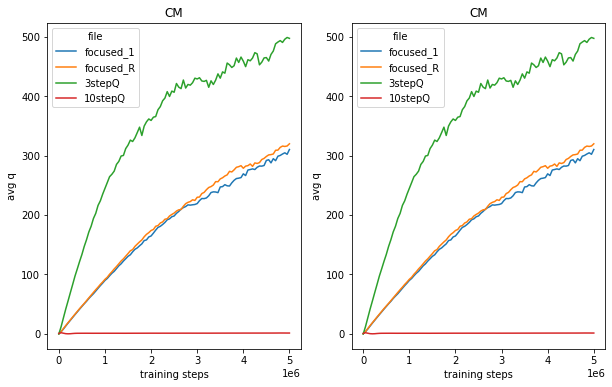

In [5]:
used_problems = ["CM", "CM"]#["AT", "BW", "CM", "DP", "TA", "TL"]

files = ["focused_1", "focused_R", "3stepQ", "10stepQ"]

f, axs = plt.subplots(1, len(used_problems), figsize=(5*len(used_problems), 6))

for i in range(len(used_problems)):
    dfs = []
    for file in files:
        dfs.append(pd.read_csv("experiments/results/"+filename([used_problems[i], 2, 2])+"/"+file+"/q.csv"))
        dfs[-1]["file"] = file
    df = pd.concat(dfs, ignore_index=True)
    df["avg q"] = -df["avg q"]
    sns.lineplot(data = df, x="training steps", y="avg q", hue="file", ax=axs[i])
    
    axs[i].set_title(used_problems[i])

plt.savefig("experiments/figures/q.jpg", dpi=200)
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.regression.linear_model import OLS
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from scipy.stats import linregress

a = 0
def plot_q_and_pred(m, df_features, features, problem):
    print(problem, m.rank_, m.intercept_)
    print(m.coef_)
    print(m.score(df_features[features], df_features["q"]))
    print(df_features["q"].min(), df_features["q"].max())
    df_features["pred"] = m.predict(df_features[features])
    df_features["pred"].plot(kind="hist")
    plt.title(("pred", problem))
    plt.show()
    plt.title("q")
    df_features["q"].plot(kind="hist")
    plt.title(("q", problem))
    plt.show()

def plot_features(problem, n, k, dir):
    df_features = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+dir+"/best.csv")
    
    features = feature_names(get_agent_info(agent_path(filename([problem, n, k]) + "/" + file, 0)), problem)
    #print(features)
    #m = LinearRegression()
    #m.fit(df_features[features], df_features["q"])
    #plot_q_and_pred(m, df_features, features, problem)
    
    constant_filter = VarianceThreshold(threshold=0)
    constant_filter.fit(df_features[features])
    constant_columns = [column for column in df_features[features].columns if column not in df_features[features].columns[constant_filter.get_support()]]
    print("Constant columns: ", constant_columns)
    X = df_features[features].loc[:, constant_filter.get_support()]
    #fvalues, pvalues = f_regression(X, df_features["q"])
    #print(fvalues.shape, pvalues.shape)
    # df_features["q"] = (df_features["q"] - df_features["q"].mean()) / df_features["q"].std()
    #m = OLS(df_features["q"], X)
    #r = m.fit()
    score = []
    for f in X.columns:
        #slope, intercept, r_value, p_value, std_err = linregress(df_features["q"], X[f])
        #score.append(r_value**2)
        x = np.array(df_features["q"])
        y = np.array(X[f])
        score.append(np.corrcoef(x, y)[0, 1]**2)
    #print(r.params)
    plt.xticks(ha='right', rotation=55, fontsize=6)
    sns.barplot(x=X.columns, y=score)
    #sns.barplot(x=X.columns, y=r.params)
    plt.title((problem, n, k))
    plt.savefig("experiments/figures/visits/features/"+filename(["features", file, problem])+".jpg", dpi=400, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "BW", "CM", "DP", "TA", "TL"]
#file = "5mill_JE20"
#problems = ["AT", "BW", "DP", "TA"]
file = "visits"
for problem, n, k in [(x, 2, 2) for x in problems]:
    plot_features(problem, n, k, file)

## Q Distribution

In [ ]:
from sklearn.linear_model import LinearRegression

def plot_features(problem, n, k, file, q_file):
    df = pd.read_csv("experiments/results/"+filename([problem, n, k])+"/"+file+"/"+q_file+".csv")
    df["q"].plot(kind='hist')
    print(df["q"].min(), df["q"].mean(), df["q"].max())
    plt.title((problem, n, k, q_file))
    #plt.savefig("experiments/figures/2h/"+t+"_features/"+filename([problem, n, k, t, ra_feature])+".jpg", dpi=200, bbox_inches="tight")
    plt.tight_layout()
    plt.show()
    

problems = ["AT", "TA", "DP"]
n, k = 2, 2
for problem in problems:
    plot_features(problem, n, k, "focused_1", q_file="best")
    plot_features(problem, n, k, "focused_1", q_file="best_4_4")

## Feature distribution

In [ ]:
features = {
            "ra feature": True,
            "context features": True,
            "labels": True,
            "state labels": True,
            "je feature": True,
            "nk feature": True,
            "prop feature": True,
            "visits feature": True
        }

n = 2
states_file = "states_visits.pkl"
dfs = []
problems = ["AT", "BW", "DP", "TA", "TL", "CM"]
for problem in problems:
    features = feature_names({f: True for f in features}, problem)
    df = {name: [] for name in features}
    with open("experiments/results/"+filename([problem, n, n])+"/"+states_file, "rb") as f:
        states = pickle.load(f)
    for s in states:
        for a in s:
            for i in range(len(features)):
                df[features[i]].append(a[i])
    df = pd.DataFrame(df)
    df["problem"] = problem
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [ ]:
for problem in problems:
    print(problem)
    dfp = df.loc[df["problem"] == problem]
    print(dfp["in PG ancestors"].value_counts())


In [ ]:
problem = "AT"
dfp = df.loc[df["problem"] == problem]
print(dfp.columns)
features = feature_names({f: True for f in ["visits feature", "prop feature"]}, problem)
print(features)
#print(dfp["in PG ancestors"].value_counts())
for name in features[-10:]:
    dfp[name].plot(kind='hist')
    plt.title((name, problem))
    plt.show()

In [2]:
## Analyzing nn weights

In [ ]:
import onnx
from onnx import numpy_helper

weights = []
for idx in range(100):
    onnx_model = onnx.load("experiments/results/AT_3_3/5mill/" + str(idx)+".onnx")
    INTIALIZERS  = onnx_model.graph.initializer
    onnx_weights = {}
    for initializer in INTIALIZERS:
        W = numpy_helper.to_array(initializer)
        onnx_weights[initializer.name] = W
    w = onnx_weights["coefficient"]
    if True:
        for key, value in onnx_weights.items():
            if key == "coefficient1":
                print(key, value.min(), value.max())
    for feature in range(w.shape[0]):
        for node in range(w.shape[1]):
            weights.append({"t": idx, "val": w[feature, node], "feature": feature, "node": node})
    
weights = pd.DataFrame(weights)

In [ ]:
for feature in range(23):
    print(feature_names({"ra feature": True}, "AT")[feature])
    df = weights.loc[weights["feature"] == feature]
    sns.lineplot(data=df, x="t", y="val", hue="node")
    plt.show()